In [ ]:
# Purpose
# 1. Subset RSO and parcel attribute CSVs by year to enable upload to GitHub
# 2. Join RSO and parcel attribute CSVs to parcel boundaries
# 3. Clip to Chinatown neighborhood
# 4. Validate join/clip results

In [1]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import pandas as pd
import geopandas as gpd

In [2]:
# Set working dir & get data
cwd = os.getcwd()
print('Current Working Directory is: ', cwd)

Current Working Directory is:  /Users/dominiqueong/Documents/CCED


In [4]:
# Import RSO CSV
rso_path = os.path.join("RSO","rso cpra workbook.xlsx.csv")
rso = pd.read_csv(rso_path,dtype=
    {
        'APN':str,
        'Prior Council District':str,
        'Council District': str
    }
)
rso.info()
# Count unique values in APN column
rso['APN'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005754 entries, 0 to 1005753
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   APN                     1005754 non-null  object 
 1   RSO Year                1005754 non-null  int64  
 2   Address                 1005748 non-null  object 
 3   City                    1005297 non-null  object 
 4   Zip                     1005735 non-null  float64
 5   RSO Units               1005754 non-null  int64  
 6   Prior Council District  1005754 non-null  object 
 7   Council District        1005754 non-null  object 
 8   Land Use Code           1005754 non-null  object 
 9   Unit Range              1005754 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 76.7+ MB


5115004006    7
4265019062    7
7465004012    7
2221004001    7
6034019025    7
             ..
5147005062    1
2036009004    1
2610011020    1
2156009008    1
2033015005    1
Name: APN, Length: 158270, dtype: int64

In [ ]:
# Create variable for RSO APNs
rso_apn = rso['APN']
# Create variable for unique RSO APNs
rso_apn_unique = np.unique(rso_apn)
# Return length of an array (number of unique APNs in array)
len(rso_apn_unique)
# Create variable for APNs with RSO Year 2022
rso_2022 = rso[rso['RSO Year']==2022]
rso_2022.to_csv('RSO_2022.csv')

In [5]:
# Import city of LA parcel SHP - clipped with ArcPro
parcels_path = os.path.join("LACounty_Parcels_City_Boundary","LACounty_Parcels_City_Boundary.zip")
parcels = gpd.read_file(parcels_path)

In [11]:
# Import Chinatown parcel SHP - clipped with ArcPro
parcel_chinatown_path = os.path.join("LA_County_Parcels_Feature_Clip.zip")
parcel_chinatown = gpd.read_file(parcel_chinatown_path,dtype={'AIN':str})

In [6]:
# Create list of RSO years
rso_years = [2016,2017,2018,2019,2020,2021]
# Filter by RSO year, write each RSO year to CSV file
for year in rso_years:
    newfile = rso[rso['RSO Year']==year]
    newfilename = 'RSO_' + str(year) +'.csv'
    newfile.to_csv(newfilename)

/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/anaconda3/lib/python3.9/site-packages/g

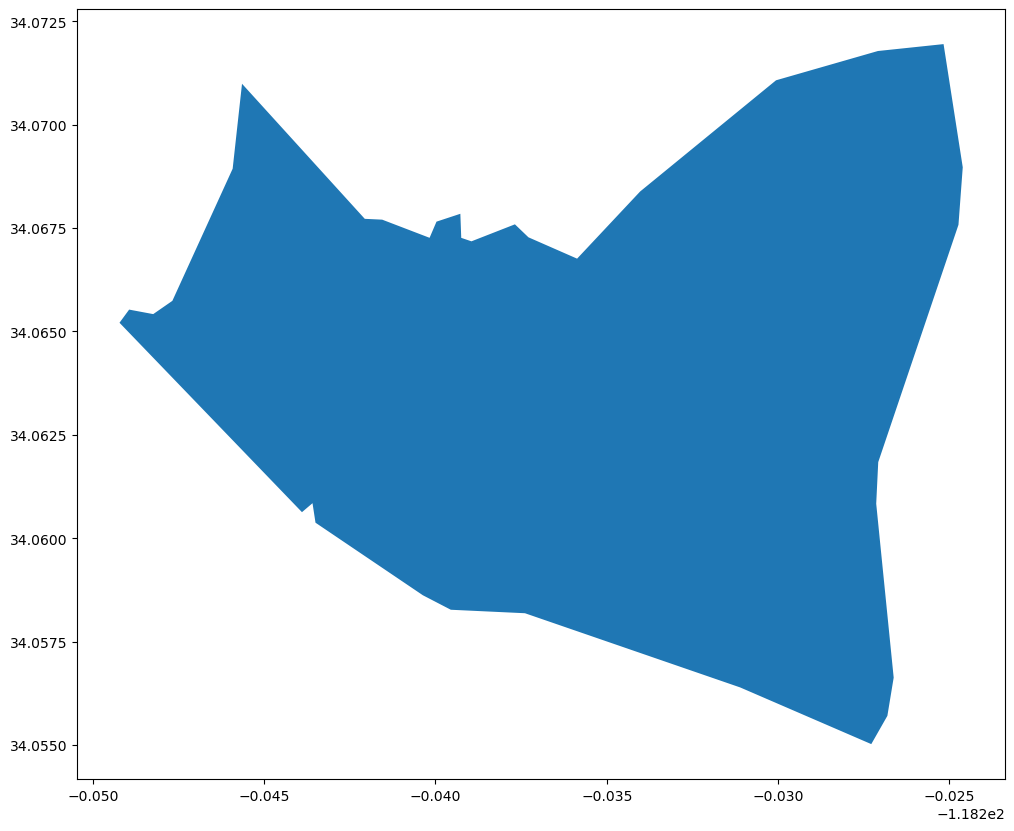

In [25]:
# Import Chinatown neighborhood boundary SHP - filtered on LA GeoHub
neighborhood_path = os.path.join("LA_Times_Neighborhood_Boundaries","Chinatown_LA_Times_Neighborhood_Boundaries.geojson")
neighborhood_bd = gpd.read_file(neighborhood_path)
# Plot Chinatown neighborhood boundary
neighborhood_bd.plot(figsize=(12,10))
# Import RSO CSVs
# Define columns to keep from RSO CSV
columns_to_keep = ['APN','RSO Year','Address','City','Zip','RSO Units','Council District']
# Define years with LAHD RSO data
years = [2016,2017,2018,2019,2020,2021,2022]
# Iterate through years to attribute join RSO CSV to parcel boundaries
for year in years:
    rso_path = os.path.join("RSO","RSO_"+ str(year) +".csv")
    rso_csv = pd.read_csv(rso_path,dtype={'APN':str})
    # Trim, rename columns in RSO CSV
    rso_trim = rso_csv[columns_to_keep]
    rso_trim.columns = ['AIN','RSO Year','Address','City','Zip','RSO Units','Council District']
    # Merge to join RSO CSV and parcel SHP
    rso_shapes = parcel_chinatown.merge(rso_trim, on='AIN')
    rso_filepath = os.path.join("RSO","rso_" + str(year) + "_shapes.geojson")
    rso_shapes.to_file(rso_filepath,driver='GeoJSON')
    # Reproject to the same CRS
    rso_shapes_prj = rso_shapes.to_crs(neighborhood_bd.crs)
    # Clip RSO geoJSON to Chinatown neighborhood boundary
    rso_shapes_clip = gpd.clip(rso_shapes_prj,neighborhood_bd)
    # Save clipped RSO geoJSON to file
    rso_shapes_clip_filepath = os.path.join("RSO","rso_" + str(year) + "_shapes_clip.geojson")
    rso_shapes_clip.to_file(rso_shapes_clip_filepath,driver='GeoJSON')

<AxesSubplot:>

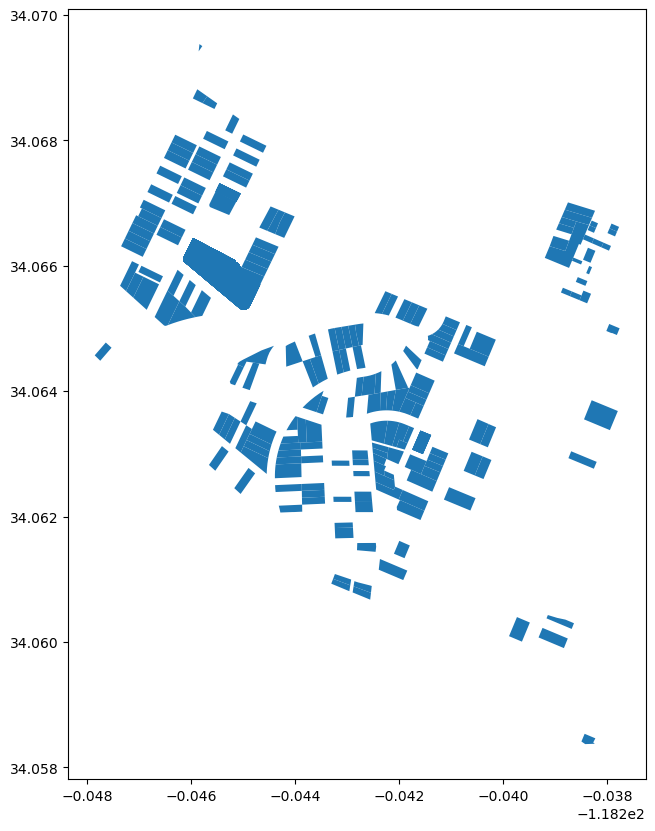

In [26]:
# Import clipped 2016-2021 RSO geoJSON
# 2016
rso_2016_shapes_clip_filepath = os.path.join("RSO","rso_2016_shapes_clip.geojson")
rso_2016_shapes_clip = gpd.read_file(rso_2016_shapes_clip_filepath)
# 2017
rso_2017_shapes_clip_filepath = os.path.join("RSO","rso_2017_shapes_clip.geojson")
rso_2017_shapes_clip = gpd.read_file(rso_2017_shapes_clip_filepath)
# 2018
rso_2018_shapes_clip_filepath = os.path.join("RSO","rso_2018_shapes_clip.geojson")
rso_2018_shapes_clip = gpd.read_file(rso_2018_shapes_clip_filepath)
# 2019
rso_2019_shapes_clip_filepath = os.path.join("RSO","rso_2019_shapes_clip.geojson")
rso_2019_shapes_clip = gpd.read_file(rso_2019_shapes_clip_filepath)
# 2020
rso_2020_shapes_clip_filepath = os.path.join("RSO","rso_2020_shapes_clip.geojson")
rso_2020_shapes_clip = gpd.read_file(rso_2020_shapes_clip_filepath)
# 2021
rso_2021_shapes_clip_filepath = os.path.join("RSO","rso_2021_shapes_clip.geojson")
rso_2021_shapes_clip = gpd.read_file(rso_2021_shapes_clip_filepath)
# 2022
rso_2022_shapes_clip_filepath = os.path.join("RSO","rso_2022_shapes_clip.geojson")
rso_2022_shapes_clip = gpd.read_file(rso_2022_shapes_clip_filepath)
# Plot clipped RSO 
rso_2022_shapes_clip.plot(figsize=(12,10))

In [28]:
# Import LA County Assessor 2006-2021 parcel CSV
# Define years in LA County Assessor data
years = [2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]
# Iterate through years to attribute join parcel CSV to parcel boundaries
for year in years:
    # Read parcel CSV for each year
    parcel_tra_path = os.path.join("Assessor_Parcels_Data_"+ str(year) +"_TRA.csv")
    parcel_tra = pd.read_csv(parcel_tra_path,dtype={'AIN':str,'PropertyUseCode':str})
    # Merge parcel CSV to parcel SHP
    parcels_shapes = parcel_chinatown.merge(parcel_tra, on='AIN')
    # Save joined parcel data to geoJSON
    filepath = os.path.join("Assessor_Parcels_Data_" + str(year) + "_TRA.geojson")
    parcels_shapes.to_file(filepath,driver='GeoJSON')

/var/folders/sf/dcmth9m12fv8jfbyt12xs88w0000gn/T/ipykernel_24800/3318410404.py:7: DtypeWarning: Columns (37) have mixed types. Specify dtype option on import or set low_memory=False.
  parcel_tra = pd.read_csv(parcel_tra_path,dtype={'AIN':str,'PropertyUseCode':str})
/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/var/folders/sf/dcmth9m12fv8jfbyt12xs88w0000gn/T/ipykernel_24800/3318410404.py:7: DtypeWarning: Columns (37) have mixed types. Specify dtype option on import or set low_memory=False.
  parcel_tra = pd.read_csv(parcel_tra_path,dtype={'AIN':str,'PropertyUseCode':str})
/opt/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.

In [29]:
# Import LA County Assessor 2016-2021 parcel geoJSON
# 2006
parcels_2006_shapes_path = os.path.join("Assessor_Parcels_Data_2006_TRA.geojson")
parcels_2006_shapes = gpd.read_file(parcels_2006_shapes_path)
# 2007
parcels_2007_shapes_path = os.path.join("Assessor_Parcels_Data_2007_TRA.geojson")
parcels_2007_shapes = gpd.read_file(parcels_2007_shapes_path)
# 2008
parcels_2008_shapes_path = os.path.join("Assessor_Parcels_Data_2008_TRA.geojson")
parcels_2008_shapes = gpd.read_file(parcels_2008_shapes_path)
# 2009
parcels_2009_shapes_path = os.path.join("Assessor_Parcels_Data_2009_TRA.geojson")
parcels_2009_shapes = gpd.read_file(parcels_2009_shapes_path)
# 2010
parcels_2010_shapes_path = os.path.join("Assessor_Parcels_Data_2010_TRA.geojson")
parcels_2010_shapes = gpd.read_file(parcels_2010_shapes_path)
# 2011
parcels_2011_shapes_path = os.path.join("Assessor_Parcels_Data_2011_TRA.geojson")
parcels_2011_shapes = gpd.read_file(parcels_2011_shapes_path)
# 2012
parcels_2012_shapes_path = os.path.join("Assessor_Parcels_Data_2012_TRA.geojson")
parcels_2012_shapes = gpd.read_file(parcels_2012_shapes_path)
# 2013
parcels_2013_shapes_path = os.path.join("Assessor_Parcels_Data_2013_TRA.geojson")
parcels_2013_shapes = gpd.read_file(parcels_2013_shapes_path)
# 2014
parcels_2014_shapes_path = os.path.join("Assessor_Parcels_Data_2014_TRA.geojson")
parcels_2014_shapes = gpd.read_file(parcels_2014_shapes_path)
# 2015
parcels_2015_shapes_path = os.path.join("Assessor_Parcels_Data_2015_TRA.geojson")
parcels_2015_shapes = gpd.read_file(parcels_2015_shapes_path)
# 2016
parcels_2016_shapes_path = os.path.join("Assessor_Parcels_Data_2016_TRA.geojson")
parcels_2016_shapes = gpd.read_file(parcels_2016_shapes_path)
# 2017
parcels_2017_shapes_path = os.path.join("Assessor_Parcels_Data_2017_TRA.geojson")
parcels_2017_shapes = gpd.read_file(parcels_2017_shapes_path)
# 2018
parcels_2018_shapes_path = os.path.join("Assessor_Parcels_Data_2018_TRA.geojson")
parcels_2018_shapes = gpd.read_file(parcels_2018_shapes_path)
# 2019
parcels_2019_shapes_path = os.path.join("Assessor_Parcels_Data_2019_TRA.geojson")
parcels_2019_shapes = gpd.read_file(parcels_2019_shapes_path)
# 2020
parcels_2020_shapes_path = os.path.join("Assessor_Parcels_Data_2020_TRA.geojson")
parcels_2020_shapes = gpd.read_file(parcels_2020_shapes_path)
# 2021
parcels_2021_shapes_path = os.path.join("Assessor_Parcels_Data_2021_TRA.geojson")
parcels_2021_shapes = gpd.read_file(parcels_2021_shapes_path)

In [31]:
# Find unique AINs for each year, print year and count of unique values
# Create function
def ain_count(parcels_year_shapes):
    ain_unique = np.unique(parcels_year_shapes['AIN'])
    print(parcels_year_shapes['RollYear'][0],len(ain_unique))
# Count unique parcels 2006-2021
ain_count(parcels_2006_shapes)
ain_count(parcels_2007_shapes)
ain_count(parcels_2008_shapes)
ain_count(parcels_2009_shapes)
ain_count(parcels_2010_shapes)
ain_count(parcels_2011_shapes)
ain_count(parcels_2012_shapes)
ain_count(parcels_2013_shapes)
ain_count(parcels_2014_shapes)
ain_count(parcels_2015_shapes)
ain_count(parcels_2016_shapes)
ain_count(parcels_2017_shapes)
ain_count(parcels_2018_shapes)
ain_count(parcels_2019_shapes)
ain_count(parcels_2020_shapes)
ain_count(parcels_2021_shapes)
# Identify which AINs are listed on 2021 parcel list but ARE NOT on 2016 parcel list
main_list = np.setdiff1d(parcels_2021_shapes['AIN'],parcels_2016_shapes['AIN'])
print(len(main_list))
# AIN count increases from 2006-2021, identify potential explanations

2006 1095
2007 1100
2008 1102
2009 1103
2010 1108
2011 1111
2012 1118
2013 1121
2014 1133
2015 1135
2016 1139
2017 1140
2018 1146
2019 1194
2020 1203
2021 1206
69
